In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Turn off warnings
warnings.filterwarnings("ignore")

from alpha_vantage.timeseries import TimeSeries

# Your Alpha Vantage API Key
api_key = "1P1GXYBY950ED7PY"

### Hong Kong Index - ISHARES MSCI HONG KONG ETF 

In [40]:
# Initialize TimeSeries object
ts = TimeSeries(key=api_key, output_format="pandas")

# Fetch daily data for Hang Seng Index (HSI)
symbol_hk = "EWH"
data_hk, metadata_hk = ts.get_daily(symbol=symbol_hk, outputsize="full")
data_hk = data_hk['4. close'].resample('ME').last()

### US Index - S&P 500

In [41]:
symbol_us = "SPY"
data_us, metadata_us = ts.get_daily(symbol=symbol_us, outputsize="full")
data_us = data_us['4. close'].resample('ME').last()

### India - MSCI India ETF

In [42]:
symbol_in = "INDA"
data_in, metadata_in = ts.get_daily(symbol=symbol_in, outputsize="full")
data_in = data_in['4. close'].resample('ME').last()

### Gold - SPDR GOLD 

In [43]:
symbol_gl = "GLD"
data_gl, metadata_gl = ts.get_daily(symbol=symbol_gl, outputsize="full")
data_gl = data_gl['4. close'].resample('ME').last()

### JAPAN - MSCI JAPAN ETF

In [44]:
symbol_jp = "JPXN"
data_jp, metadata_jp = ts.get_daily(symbol=symbol_jp, outputsize="full")
data_jp = data_jp['4. close'].resample('ME').last()

### Data Cleaning and Processing

In [54]:
data_combined = pd.concat([data_in, data_us, data_hk, data_jp, data_gl], axis=1)
df = data_combined.dropna()
df.columns = ['MSCI India ETF', 'SPY S&P 500 ETF', 'MSCI Hong Kong ETF', 'ISHARES JPX-NIKKEI 400 ETF', 'SPDR GOLD ETF']
df

,MSCI India ETF,SPY S&P 500 ETF,MSCI Hong Kong ETF,ISHARES JPX-NIKKEI 400 ETF,SPDR GOLD ETF
date,,,,,
2012-02-29,26.00,137.02,18.245,42.9300,164.286
2012-03-31,24.85,140.81,17.445,43.4600,162.120
2012-04-30,23.64,139.87,17.550,41.8910,161.880
2012-05-31,20.80,131.47,15.920,38.0300,151.620
2012-06-30,22.56,136.10,16.400,40.1500,155.190
...,...,...,...,...,...
2024-10-31,54.82,568.64,17.870,72.4650,253.510
2024-11-30,54.78,602.55,17.440,73.9700,245.590
2024-12-31,52.64,586.08,16.660,70.8069,242.130


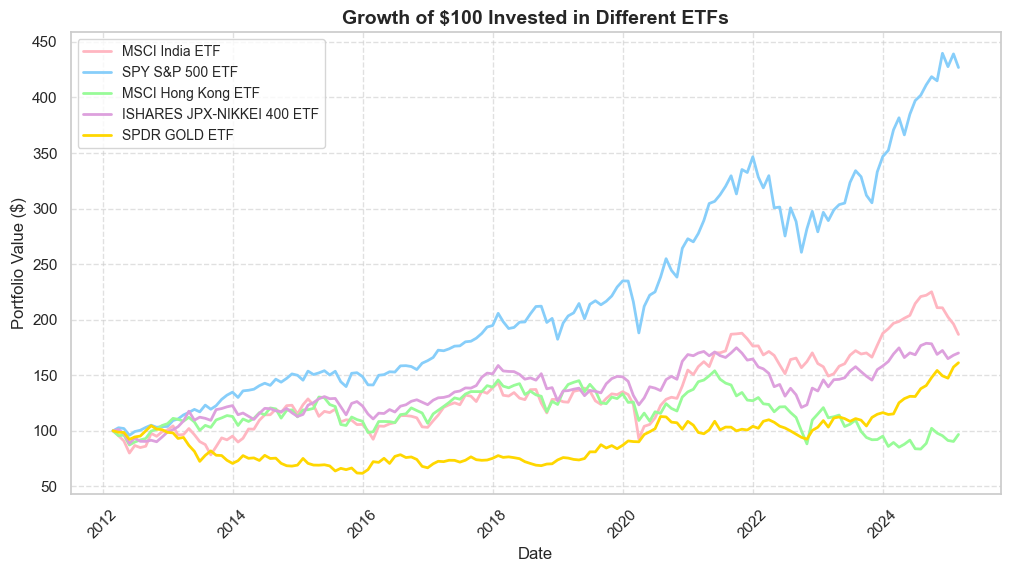

In [56]:
import seaborn as sns

# Normalize prices: INR 100 invested at the start
df_normalized = df / df.iloc[0] * 100  

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Define pastel colors
colors = ["#FFB6C1", "#87CEFA", "#98FB98", "#DDA0DD", "#FFD700"]  # Adjust as needed

# Plot each ETF's growth
for i, column in enumerate(df_normalized.columns):
    plt.plot(df_normalized.index, df_normalized[column], label=column, color=colors[i % len(colors)], linewidth=2)

# Formatting
plt.title("Growth of $100 Invested in Different ETFs", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


## Gold vs NIFTY

[*********************100%***********************]  2 of 2 completed


<Figure size 1200x600 with 0 Axes>

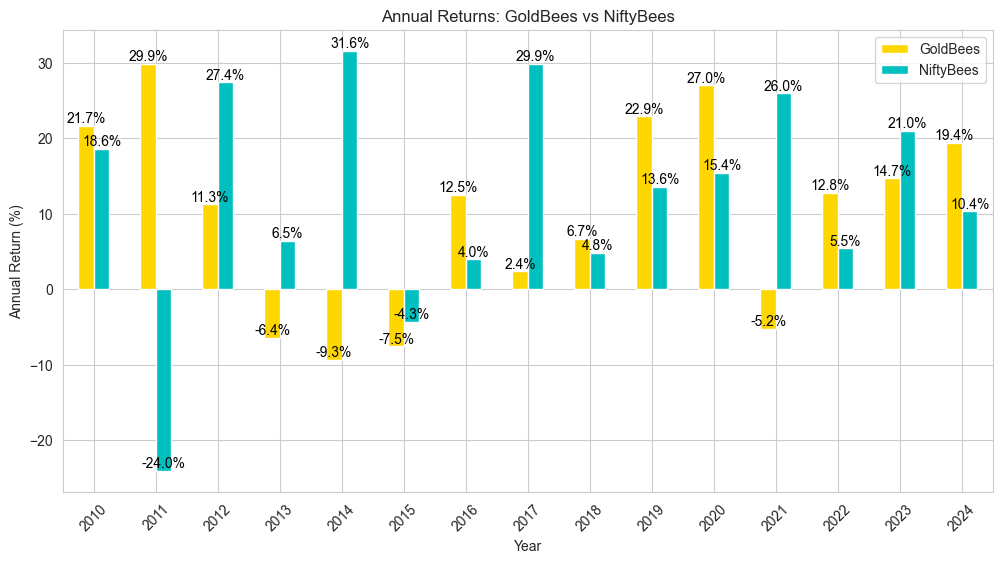

In [19]:
# Download historical data for GoldBees and NiftyBees
tickers = ["GOLDBEES.NS", "NIFTYBEES.NS"]
data = yf.download(tickers, start="2000-01-01", end="2025-01-01", interval="1mo")['Close']

# Resample to get year-end prices
annual_prices = data.resample('Y').last()

# Calculate annual returns
annual_returns = annual_prices.pct_change().dropna() * 100
annual_returns.index = annual_returns.index.year
# Plotting
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")


# Create bar plot
ax = annual_returns.plot(kind='bar', figsize=(12,6), color=["gold", "c"])


# Add labels
plt.title("Annual Returns: GoldBees vs NiftyBees")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.legend(["GoldBees", "NiftyBees"])
# plt.xticks(ticks=range(len(annual_returns.index.unique())), labels=annual_returns.index.unique(), rotation=0)
plt.xticks(rotation=45)

# Show values on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black")

plt.show()


SMALL VS MID VS Large

In [ ]:


# Define index symbols
indices = {
    "NIFTY 50 SBI ETF": "SETFNIF50.NS",
    "MIDCAP 100 MOTILAL OSWAL ETF": "MOM100.NS",
    "NIPPON SMALL CAP FUND": "0P0000XVFY.BO"
}

# Download historical data (adjusted close prices)
start_date = "2005-01-01"
end_date = "2024-12-31"
data = yf.download(list(indices.values()), start=start_date, end=end_date)['Close']

data = data.dropna()

# Normalize to 100 (Base = first available value)
data_normalized = data / data.iloc[0] * 100

# Plot the normalized growth of indices
plt.figure(figsize=(12, 6))
for name, symbol in indices.items():
    sns.lineplot(data_normalized[symbol], label=name)

plt.xlabel("Year")
plt.ylabel("Growth of INR 100")
plt.title("Growth of NIFTY 50, NIFTY MIDCAP 100, SMALLCAP")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Sectors

In [20]:
import yfinance as yf
import matplotlib.pyplot as plt

# List of top NIFTY sector indices (tickers from NSE)
nifty_sector_tickers = {
    "NIFTY IT": "^CNXIT",
    "NIFTY Bank": "^NSEBANK",
    "NIFTY Auto": "^CNXAUTO",
    "NIFTY FMCG": "^CNXFMCG",
    "NIFTY Pharma": "^CNXPHARMA",
    "NIFTY Energy": "^CNXENERGY",
    "NIFTY Infra": "^CNXINFRA",
    "NIFTY Metal": "^CNXMETAL",
    "NIFTY Realty": "^CNXREALTY",
    "NIFTY PSU Bank": "^CNXPSUBANK"
}

# Download historical data
start_date = "2010-01-01"
end_date = "2024-02-29"
sector_data = yf.download(list(nifty_sector_tickers.values()), start=start_date, end=end_date)["Adj Close"]

# Rename columns for better readability
sector_data.columns = nifty_sector_tickers.keys()

# Plot
plt.figure(figsize=(12, 6))
for sector in sector_data.columns:
    plt.plot(sector_data.index, sector_data[sector], label=sector)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.title("Historical Performance of Top NIFTY Sector Indices (2010-2024)")
plt.grid(True)
plt.show()


[*********************100%***********************]  10 of 10 completed

1 Failed download:
['^CNXPHARMA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-02-29)')


ValueError: Length mismatch: Expected axis has 1 elements, new values have 10 elements